In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:

#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#phase_dir = '../phased_ihart.ms2_del'
#sim_file = '../sibpair_similarity/ihart.ms2_del_similarity.txt'

ped_file = '../../DATA/ihart.ms2/ihart.ped'
phase_dir = '../phased_ihart.ms2_quads_del'
sim_file = '../sibpair_similarity/ihart.ms2_quads_del_similarity.txt'

#ped_file = '../../DATA/spark/spark.ped'
#phase_dir = '../phased_spark_del'
#sim_file = '../sibpair_similarity/spark_del_similarity.txt'

#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#phase_dir = '../phased_ssc.hg38_del'
#sim_file = '../sibpair_similarity/ssc.hg38_del_similarity.txt'


In [3]:
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']

In [4]:
def get_data(ped_file, phase_dir, sim_file):
    sibpair_to_sim = dict()
    with open(sim_file, 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            sibpair_to_sim[(pieces[0], tuple(sorted([pieces[1], pieces[2]])))] = (float(pieces[3]), float(pieces[4]))

    # pull affected status
    # (0=unknown; 1=unaffected; 2=affected)
    child_id_to_affected = dict()
    child_id_to_sex = dict()
    fam_to_inds = dict()
    in_ped = set()
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if f_id != '0' and m_id != '0':
                    if (fam_id, m_id, f_id) not in fam_to_inds:
                        fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                    fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                in_ped.add(m_id)
                in_ped.add(f_id)
                in_ped.add(child_id)

    print('ped loaded')
    print('children', len(child_id_to_affected))

    with open('%s/deletions.json' % phase_dir) as f:
        deletions = json.load(f)

    # filter deletions
    deletions = [d for d in deletions if d['length']>=100]
    print('remaining deletions', len(deletions))
    #
    deletions = [d for d in deletions if d['is_inherited']]
    print('remaining deletions', len(deletions))

    return fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim

fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim = get_data(ped_file, phase_dir, sim_file)
#ssc_fam_to_inds, ssc_child_id_to_affected, ssc_child_id_to_sex, ssc_deletions, ssc_sibpair_to_sim = get_data(ssc_ped_file, ssc_phase_dir, ssc_sim_file)

ped loaded
children 4611
remaining deletions 329201
remaining deletions 329201


In [115]:
child_id_to_phen = dict()
with open('../phenotypes/ihart/SRS/SRS2_SRS20021_Child.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    id_index, phen_index = header.index('Individual ID'), header.index('MotivQ6')
    for line in reader:
        child_id_to_phen[line[id_index]] = int(line[phen_index])

['FormID', 'Version', 'PatientNum', 'ProjectNum', 'ProjectName', 'Gender', 'Individual ID', 'data_entry_date', 'original_source_name', ' original_source_id', 'AU/Family ID', 'NDAR_GUID', 'Status', 'InterviewMonth', 'InterviewDay', 'InterviewYear', 'age', 'Interviewernum', 'Interviewer_Org', 'Validated', 'SRS_Gender', 'SRS_Respond', 'SRS_Respond_Detail', 'SRS_Respond_Detail_oth_spec', 'MotivQ1', 'AwareQ2', 'MotivQ3', 'MannerQ4', 'CogQ5', 'MotivQ6', 'AwareQ7', 'MannerQ8', 'MotivQ9', 'CogQ10', 'MotivQ11', 'CommQ12', 'CommQ13', 'MannerQ14', 'CogQ15', 'CommQ16', 'CogQ17', 'CommQ18', 'CommQ19', 'MannerQ20', 'CommQ21', 'CommQ22', 'MotivQ23', 'MannerQ24', 'AwareQ25', 'CommQ26', 'MotivQ27', 'MannerQ28', 'MannerQ29', 'CogQ30', 'MannerQ31', 'AwareQ32', 'CommQ33', 'MotivQ34', 'CommQ35', 'CommQ36', 'CommQ37', 'CommQ38', 'MannerQ39', 'CogQ40', 'CommQ41', 'CogQ42', 'MotivQ43', 'CogQ44', 'AwareQ45', 'CommQ46', 'CommQ47', 'CogQ48', 'MannerQ49', 'MannerQ50', 'CommQ51', 'AwareQ52', 'CommQ53', 'AwareQ54',

No handles with labels found to put in legend.


Mat/Pat ihart Ttest_indResult(statistic=28.170170105361827, pvalue=2.1900445238846384e-174)


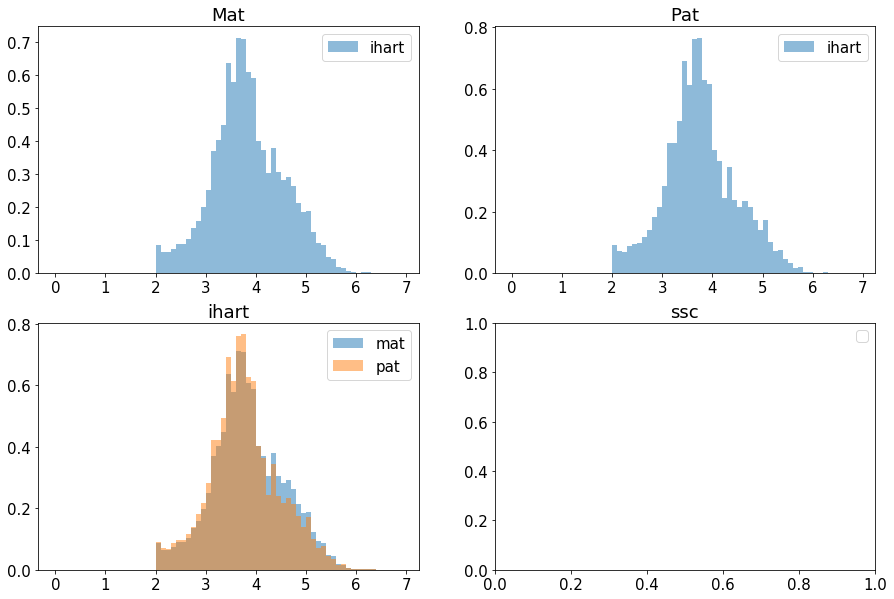

In [116]:
bins=np.arange(0, 7, 0.1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Mat')

plt.subplot(2, 2, 2)
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Pat')

#print('Mat ihart/ssc', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_mat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_mat']])))
#print('Pat ihart/ssc', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_pat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_pat']])))

plt.subplot(2, 2, 3)
plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='mat')
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ihart')

plt.subplot(2, 2, 4)
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), alpha=0.5, bins=bins, density=True, label='mat')
#plt.hist(np.log10([d['length'] for d in ssc_deletions if d['is_pat']]), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ssc')

print('Mat/Pat ihart', stats.ttest_ind(np.log10([d['length'] for d in deletions if d['is_mat']]), 
                      np.log10([d['length'] for d in deletions if d['is_pat']])))
#print('Mat/Pat ssc', stats.ttest_ind(np.log10([d['length'] for d in ssc_deletions if d['is_mat']]), 
#                      np.log10([d['length'] for d in ssc_deletions if d['is_pat']])))
plt.show()


In [117]:
def get_mad_outliers(x):
    median = np.median(x, axis=0)
    diff = np.abs(x - median)
    mad = np.median(diff)
    
    is_outlier = 0.6745 * diff/mad > 4
    
    #plt.hist([x[~is_outlier], x[is_outlier]], stacked=True)
    #plt.show()
    
    return is_outlier

def get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim):
    
    sibpairs = sorted(sibpair_to_sim.keys())
    sibpairs = [(fam, x) for (fam, x) in sibpairs if x[0] in child_id_to_phen and x[1] in child_id_to_phen and \
                        child_id_to_phen[x[0]] != -1 and child_id_to_phen[x[1]] != -1]
    
    print('sibpairs', len(sibpairs))
    sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])
    
    # sibpair, mat/pat
    sim = np.array([sibpair_to_sim[x][:2] for x in sibpairs])
                      
    # sibpair, mat/pat
    deletions_match = np.zeros((len(sibpairs), 2), dtype=int)    
    
    # child, mat/pat
    children = sorted(set([(fam, sib1) for fam, (sib1, sib2) in sibpairs] + [(fam, sib2) for fam, (sib1, sib2) in sibpairs]))
    child_to_index = dict([(x, i) for i, x in enumerate(children)])
    child_deletions = np.zeros((len(children), 2), dtype=int) 
    
    for d in deletions:
        for sib1, sib2 in combinations(d['trans'], 2):
            key = (d['family'], tuple(sorted([sib1, sib2])))
            if key in sibpair_to_index:
                deletions_match[sibpair_to_index[key], int(d['is_pat'])] += d['length']

        for child in d['trans']:
            key = (d['family'], child)
            if key in child_to_index:
                child_deletions[child_to_index[key], int(d['is_pat'])] += d['length']
            
    is_outlier = np.zeros((len(sibpairs),), dtype=bool)    
    for key, x in [('sim', sim)]:#, ('deletions_match', np.log10(deletions_match))]:
        mat_outliers = get_mad_outliers(x[:, 0])
        pat_outliers = get_mad_outliers(x[:, 1])
        
        print(key, 'outliers', np.sum(mat_outliers), np.sum(pat_outliers))
        
        is_outlier[mat_outliers | pat_outliers] = True
        
    child_to_indices = defaultdict(list)
    for i, (fam, (sib1, sib2)) in enumerate(sibpairs):
        child_to_indices[(fam, sib1)].append(i)
        child_to_indices[(fam, sib2)].append(i)
        
    child_is_outlier = get_mad_outliers(np.log10(child_deletions[:, 0])) | get_mad_outliers(np.log10(child_deletions[:, 1]))
    print('child outliers', np.sum(child_is_outlier))
    for i in np.where(child_is_outlier)[0]:
        is_outlier[child_to_indices[children[i]]] = True

    sibpairs = [x for x, b in zip(sibpairs, is_outlier) if not b]
    sim = sim[~is_outlier, :]
    deletions_match = deletions_match[~is_outlier, :]
    
    phen_diff = np.abs(np.array([child_id_to_phen[sib1]-child_id_to_phen[sib2] for fam, (sib1, sib2) in sibpairs]))

    is_f_f = np.array([(child_id_to_sex[sib1]=='2') and (child_id_to_sex[sib2]=='2') for fam, (sib1, sib2) in sibpairs])
    is_f_m = np.array([((child_id_to_sex[sib1]=='1') and (child_id_to_sex[sib2]=='2')) or ((child_id_to_sex[sib1]=='2') and (child_id_to_sex[sib2]=='1')) for fam, (sib1, sib2) in sibpairs])
    is_m_m = np.array([(child_id_to_sex[sib1]=='1') and (child_id_to_sex[sib2]=='1') for fam, (sib1, sib2) in sibpairs])


    return sibpairs, sim, deletions_match, phen_diff, is_f_f, is_f_m, is_m_m

sibpairs, sim, deletions_match, phen_diff, is_f_f, is_f_m, is_m_m = get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim)


sibpairs 770
sim outliers 46 43
child outliers 16


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


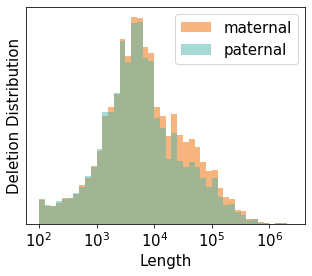

In [118]:
bins=np.arange(2, 6.5, 0.1)

plt.figure(figsize=(5, 4))

plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins, label='maternal', color=colors[0])
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins, label='paternal', color=colors[1])
plt.legend()
#plt.title('Deletion Lengths')
plt.xticks(np.arange(2, 7), ['$10^{%d}$' % d for d in np.arange(2, 7)])
plt.yticks([])
plt.ylabel('Deletion Distribution')
plt.xlabel('Length')
plt.show()


In [119]:
print(sibpairs[0])

('AU0012.AU001203.AU001204', ('AU001203', 'AU001204'))


In [120]:
# pick independent sibpairs
ind_probands = set()
for fam, inds in fam_to_inds.items():
    aut_children = [x for x in inds[2:] if child_id_to_affected[x]=='2']
    if len(aut_children)> 0:
        ind_probands.add(random.choice(aut_children))
print(len(ind_probands))

is_ind_sibpair = np.array([x[0] in ind_probands or x[1] in ind_probands for f, x in sibpairs])
print(np.sum(is_ind_sibpair))

1038
518


No handles with labels found to put in legend.


Mat/Pat ihart Ttest_indResult(statistic=-0.08210045068076696, pvalue=0.9345782445715254)


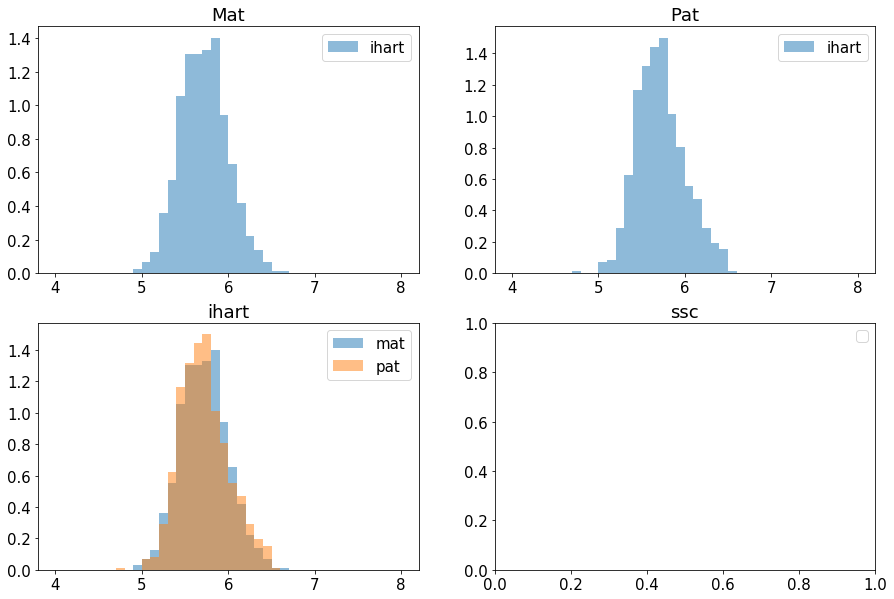

In [121]:
bins=np.arange(4, 8.1, 0.1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(np.clip(np.log10(deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Mat')

plt.subplot(2, 2, 2)
plt.hist(np.clip(np.log10(deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='ihart')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='ssc')
plt.legend()
plt.title('Pat')

#print('Mat ihart/ssc', stats.ttest_ind(np.log10(deletions_match[:, 0]), np.log10(ssc_deletions_match[:, 0])))
#print('Pat ihart/ssc', stats.ttest_ind(np.log10(deletions_match[:, 1]), np.log10(ssc_deletions_match[:, 1])))


plt.subplot(2, 2, 3)
plt.hist(np.clip(np.log10(deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='mat')
plt.hist(np.clip(np.log10(deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ihart')

plt.subplot(2, 2, 4)
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 0]), 4, 8), alpha=0.5, bins=bins, density=True, label='mat')
#plt.hist(np.clip(np.log10(ssc_deletions_match[:, 1]), 4, 8), alpha=0.5, bins=bins, density=True, label='pat')
plt.legend()
plt.title('ssc')

print('Mat/Pat ihart', stats.ttest_ind(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1])))
#print('Mat/Pat ssc', stats.ttest_ind(np.log10(ssc_deletions_match[:, 0]), np.log10(ssc_deletions_match[:, 1])))

plt.show()


(0.12500513242053726, 0.0007683610259697826)
(0.284011486046875, 7.63351552889849e-15)
(0.0452982633110475, 0.22442828466328563)
(-0.0144855946263671, 0.6977906217393832)


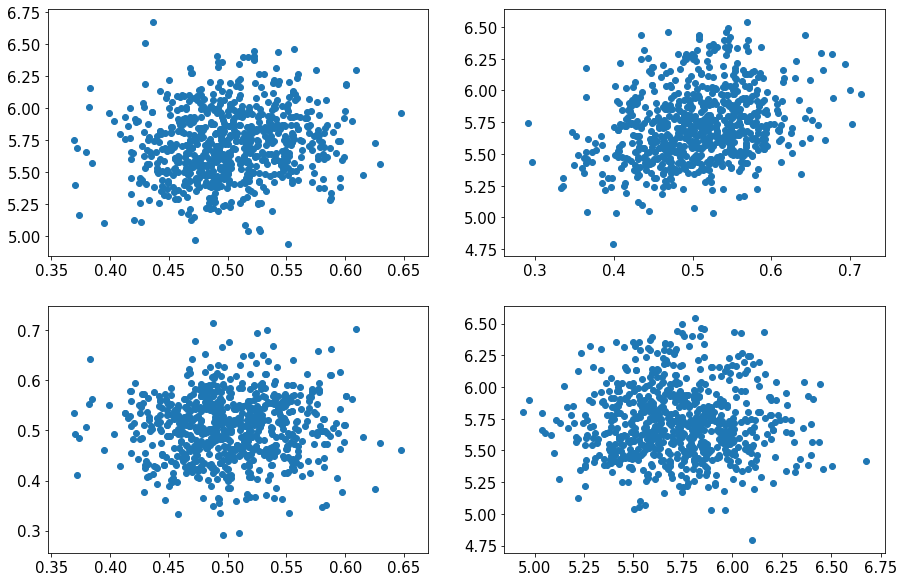

In [122]:
#print(np.var(mat_sim[mat_has_data]), np.var(mat_jaccard[mat_has_data]))
#print(np.var(pat_sim[pat_has_data]), np.var(pat_jaccard[pat_has_data]))

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(sim[:, 0], np.log10(deletions_match[:, 0]))
print(stats.pearsonr(sim[:, 0], np.log10(deletions_match[:, 0])))
#plt.xlim([0, 1])

plt.subplot(2, 2, 2)
plt.scatter(sim[:, 1], np.log10(deletions_match[:, 1]))
print(stats.pearsonr(sim[:, 1], np.log10(deletions_match[:, 1])))
#plt.xlim([0, 1])

plt.subplot(2, 2, 3)
plt.scatter(sim[:, 0], sim[:, 1])
print(stats.pearsonr(sim[:, 0], sim[:, 1]))
#plt.xlim([0, 1])
#plt.ylim([0, 1])

plt.subplot(2, 2, 4)
plt.scatter(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1]))
print(stats.pearsonr(np.log10(deletions_match[:, 0]), np.log10(deletions_match[:, 1])))


plt.show()

In [123]:
print(np.sum(proband_is_f), np.sum(sibling_is_f), np.sum(proband_is_f & sibling_is_f))

217 230 86


In [124]:
print(sim.shape, proband_is_f.shape)

(721, 2) (724,)


(721, 7) (721,)
942 721
Optimization terminated successfully.
         Current function value: 1.324249
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  721
Model:                        MNLogit   Df Residuals:                      700
Method:                           MLE   Df Model:                           18
Date:                Thu, 15 Jul 2021   Pseudo R-squ.:                 0.01422
Time:                        14:58:58   Log-Likelihood:                -954.78
converged:                       True   LL-Null:                       -968.55
Covariance Type:            nonrobust   LLR p-value:                   0.06947
                   y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mat_genomic_similarity     2.1312      2.171      0.982     

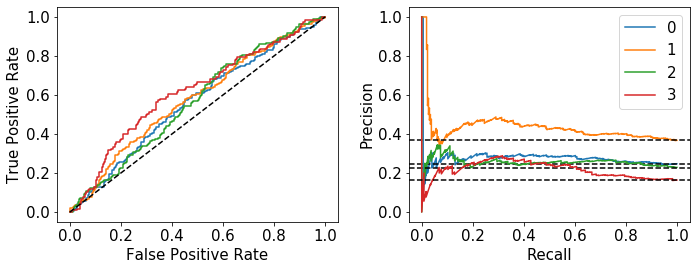

In [125]:
#from patsy import dmatrix

X = np.vstack((sim.T, 
                deletions_match.T/1000000,
                is_f_f, is_f_m, is_m_m
                  )).T
y = phen_diff

#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]


print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.MNLogit(y, X)
model.exog_names[:] = ['mat_genomic_similarity', 'pat_genomic_similarity',
                       'mat_match_del', 'pat_match_del',
                       'is_f_f', 'is_f_m', 'is_m_m'
                      ]
result = model.fit()
print(result.summary())
#print(stats.pearsonr(y, result.predict(X)), stats.pearsonr(y, result.predict(X))[0]**2)

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for i in range(4):
    sensitivity, specificity, _ = roc_curve(y==i, result.predict(X)[:, i])
    plt.plot(sensitivity, specificity, label=str(i))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

for i in range(4):
    precision, recall, _ = precision_recall_curve(y==i, result.predict(X)[:, i])
    plt.plot(recall, precision, label=str(i))
    plt.axhline(np.sum(y==i)/len(y), color='black', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

#baseline_result = result

(721, 7) (721,)
545 721
Optimization terminated successfully.
         Current function value: 0.552122
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  721
Model:                        MNLogit   Df Residuals:                      714
Method:                           MLE   Df Model:                            6
Date:                Thu, 15 Jul 2021   Pseudo R-squ.:                0.006558
Time:                        14:58:58   Log-Likelihood:                -398.08
converged:                       True   LL-Null:                       -400.71
Covariance Type:            nonrobust   LLR p-value:                    0.5115
                   y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mat_genomic_similarity     0.5013      1.922      0.261     

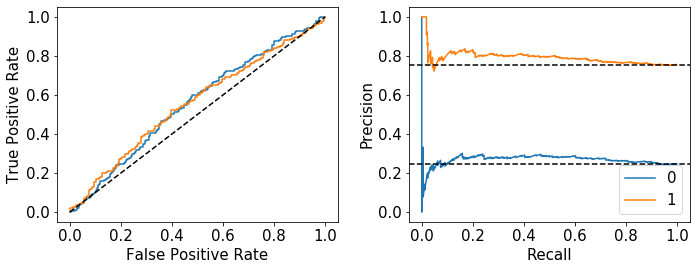

In [126]:
#from patsy import dmatrix

X = np.vstack((sim.T, 
                deletions_match.T/1000000,
                is_f_f, is_f_m, is_m_m
                  )).T
y = phen_diff>0

#X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data, :]
#y = is_aut_aut[mat_has_data & pat_has_data] | is_nt_nt[mat_has_data & pat_has_data]


print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.MNLogit(y, X)
model.exog_names[:] = ['mat_genomic_similarity', 'pat_genomic_similarity',
                       'mat_match_del', 'pat_match_del',
                       'is_f_f', 'is_f_m', 'is_m_m'
                      ]
result = model.fit()
print(result.summary())
#print(stats.pearsonr(y, result.predict(X)), stats.pearsonr(y, result.predict(X))[0]**2)

matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for i in range(2):
    sensitivity, specificity, _ = roc_curve(y==i, result.predict(X)[:, i])
    plt.plot(sensitivity, specificity, label=str(i))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.legend()

plt.subplot(1, 2, 2)
#precision, recall, _ = precision_recall_curve(y==2, result.predict(X)[:, 2])
#plt.plot(recall, precision, label='aut-aut')
#plt.axhline(np.sum(y==2)/len(y), color='black', linestyle='--')

for i in range(2):
    precision, recall, _ = precision_recall_curve(y==i, result.predict(X)[:, i])
    plt.plot(recall, precision, label=str(i))
    plt.axhline(np.sum(y==i)/len(y), color='black', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')



plt.legend()

plt.tight_layout()
plt.show()

#baseline_result = result

In [127]:
print(result.params[2], np.exp(result.params[2]), 
      np.exp(result.params[2]-result.bse[2]),
      np.exp(result.params[2]+result.bse[2]))

print(result.params[3], np.exp(result.params[3]), 
      np.exp(result.params[3]-result.bse[3]),
      np.exp(result.params[3]+result.bse[3]))


[0.02859839] [1.02901125] [0.85410332] [1.23973777]
[0.22568007] [1.25317467] [1.03938339] [1.51094079]


In [101]:
indices = np.hstack((np.random.choice(np.where(proband_is_f & sibling_is_f)[0], size=np.sum(proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(proband_is_f & ~sibling_is_f)[0], size=np.sum(proband_is_f & ~sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & sibling_is_f)[0], size=np.sum(~proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & ~sibling_is_f)[0], size=np.sum(~proband_is_f & ~sibling_is_f)),
                    ))
print(indices.shape)


(724,)


In [102]:
pvalues, reverse_pvalues = [], []
coeffs, reverse_coeffs = [], []

for i in range(1000):
    sibpairs, sim, deletions_match, proband_deletions, sibling_deletions, \
            phen_diff, proband_is_f, sibling_is_f = get_matches(fam_to_inds, child_id_to_affected, child_id_to_sex, deletions, sibpair_to_sim)

    X = np.vstack((sim.T,
               (deletions_match.T/1000000) * proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * proband_is_f * ~sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * sibling_is_f,
               (deletions_match.T/1000000) * ~proband_is_f * ~sibling_is_f,
               proband_is_f * sibling_is_f,
               proband_is_f * ~sibling_is_f,
               ~proband_is_f * sibling_is_f,
               ~proband_is_f * ~sibling_is_f,
                  )).T
    y = is_aut_aut
    
    indices = np.hstack((np.random.choice(np.where(proband_is_f & sibling_is_f)[0], size=np.sum(proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(proband_is_f & ~sibling_is_f)[0], size=np.sum(proband_is_f & ~sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & sibling_is_f)[0], size=np.sum(~proband_is_f & sibling_is_f)),
                     np.random.choice(np.where(~proband_is_f & ~sibling_is_f)[0], size=np.sum(~proband_is_f & ~sibling_is_f)),
                    ))

    model = sm.Logit(y[indices], X[indices, :])
    result = model.fit()
    
    pvalues.append(result.pvalues)
    coeffs.append(result.params)
    
    #X = np.vstack((reverse_sim.T,
    #           (reverse_deletions_match.T/1000000) * reverse_proband_is_f * reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * reverse_proband_is_f * ~reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * ~reverse_proband_is_f * reverse_sibling_is_f,
    #           (reverse_deletions_match.T/1000000) * ~reverse_proband_is_f * ~reverse_sibling_is_f,
    ##           reverse_proband_is_f * reverse_sibling_is_f,
     #          reverse_proband_is_f * ~reverse_sibling_is_f,
    ##           ~reverse_proband_is_f * reverse_sibling_is_f,
    #           ~reverse_proband_is_f * ~reverse_sibling_is_f,
    #              )).T
    #y = reverse_is_nt_nt
    #
    #model = sm.Logit(y, X)
    #result = model.fit()
    #
    #reverse_pvalues.append(result.pvalues)
    #reverse_coeffs.append(result.params)


sibpairs 773
sim outliers 46 43
child outliers 16


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


ValueError: not enough values to unpack (expected 8, got 7)

In [1391]:
pvalues = np.array(pvalues)
#reverse_pvalues = np.array(reverse_pvalues)

coeffs = np.array(coeffs)
#reverse_coeffs = np.array(reverse_coeffs)

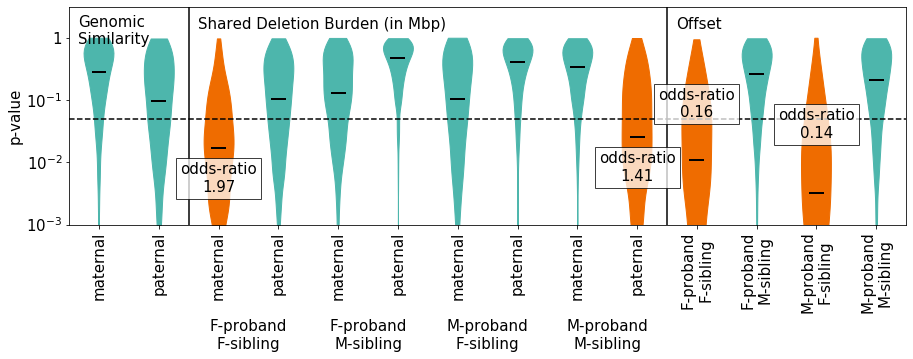

In [1392]:

fig = plt.figure(figsize=(15, 4))

#ax = plt.subplot(1, 3, 1)
parts = plt.violinplot(np.log10(pvalues), showmedians=True, showextrema=False)
plt.axhline(np.log10(0.05), color='black', linestyle='--')
plt.xticks(np.arange(1, 15), ['maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'F-proband\nF-sibling', 'F-proband\nM-sibling', 'M-proband\nF-sibling', 'M-proband\nM-sibling'
                      ], rotation=90)
plt.text(0.65, -0.1, 'Genomic\nSimilarity')
plt.text(2.65, 0.15, 'Shared Deletion Burden (in Mbp)')
plt.text(10.65, 0.15, 'Offset')

plt.text(3.5, -5, 'F-proband\nF-sibling', ha='center')
plt.text(5.5, -5, 'F-proband\nM-sibling', ha='center')
plt.text(7.5, -5, 'M-proband\nF-sibling', ha='center')
plt.text(9.5, -5, 'M-proband\nM-sibling', ha='center')

plt.text(3, np.median(np.log10(pvalues[:, 2]))-0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 2])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(10, np.median(np.log10(pvalues[:, 9]))-0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 9])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(11, np.median(np.log10(pvalues[:, 10]))+0.7, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 10])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(13, np.median(np.log10(pvalues[:, 12]))+0.9, 'odds-ratio\n%0.2f' % np.exp(np.median(coeffs[:, 12])), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))

plt.axvline(2.5, color='black')
plt.axvline(10.5, color='black')

plt.yticks(np.arange(-3, 1), ['1' if d==0 else '$10^{%d}$' % d for d in np.arange(-3, 1)])
plt.ylim([-3, 0.5])
plt.xlim([0.5, 14.5])
plt.ylabel('p-value')

for pc, x in zip(parts['bodies'], np.median(pvalues, axis=0)):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.show()
#fig.savefig('../plots/delburden.png', dpi=fig.dpi, bbox_inches='tight')


0.706 1.992 0.008
0.373 0.062 1.938
0.608 1.976 0.024


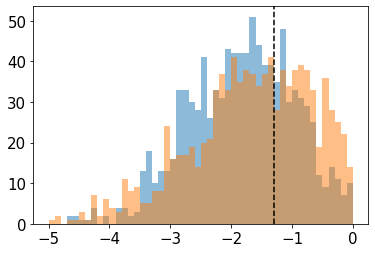

In [1393]:
print(np.sum(pvalues[:, 2]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 2]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 2]<0)/coeffs.shape[0])*2)
print(np.sum(pvalues[:, 3]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 3]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 3]<0)/coeffs.shape[0])*2)
print(np.sum(pvalues[:, 9]<0.05)/pvalues.shape[0],
      (np.sum(coeffs[:, 9]>0)/coeffs.shape[0])*2,
      (np.sum(coeffs[:, 9]<0)/coeffs.shape[0])*2)

plt.hist(np.log10(pvalues[:, 2]), alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.hist(np.log10(pvalues[:, 9]), alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.axvline(np.log10(0.05), color='black', linestyle='--')
plt.show()

In [1495]:
print(np.sum(is_aut_aut), np.sum(is_aut_nt))

1053 870


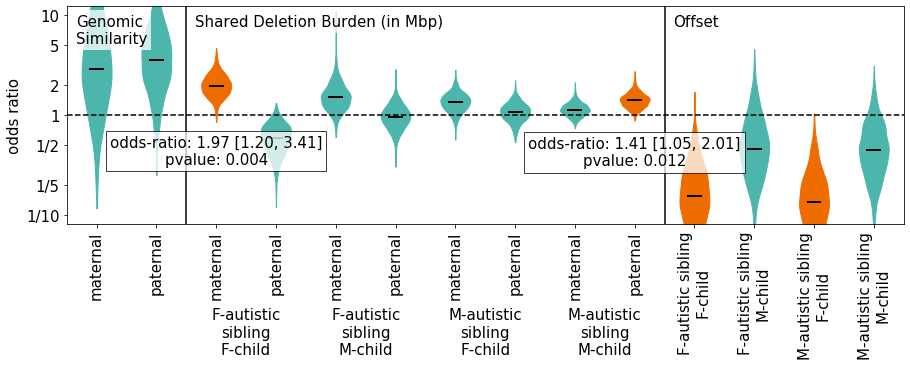

In [1499]:

fig = plt.figure(figsize=(15, 4))

#ax = plt.subplot(1, 3, 1)
parts = plt.violinplot(coeffs, showmedians=True, showextrema=False)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(np.arange(1, 15), ['maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'maternal', 'paternal',
                       'F-autistic sibling\nF-child', 'F-autistic sibling\nM-child', 
                              'M-autistic sibling\nF-child', 'M-autistic sibling\nM-child'
                      ], rotation=90)
plt.text(0.65, 1.65, 'Genomic\nSimilarity', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))
plt.text(2.65, 2.05, 'Shared Deletion Burden (in Mbp)', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))
plt.text(10.65, 2.05, 'Offset', bbox=dict(facecolor='white', alpha=0.75, linewidth=0))

plt.text(3.5, -5.5, 'F-autistic\nsibling\nF-child', ha='center')
plt.text(5.5, -5.5, 'F-autistic\nsibling\nM-child', ha='center')
plt.text(7.5, -5.5, 'M-autistic\nsibling\nF-child', ha='center')
plt.text(9.5, -5.5, 'M-autistic\nsibling\nM-child', ha='center')

plt.text(3, np.median(coeffs[:, 2])-1.8, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 2])),
                                                                                              np.exp(np.quantile(coeffs[:, 2], 0.025)),
                                                                                              np.exp(np.quantile(coeffs[:, 2], 0.975)),
                                                                                              np.sum(coeffs[:, 2]<=0)/coeffs.shape[0],
                                                                              ), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))
plt.text(10, np.median(coeffs[:, 9])-1.5, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 9])),
                                                                                               np.exp(np.quantile(coeffs[:, 9], 0.025)),
                                                                                               np.exp(np.quantile(coeffs[:, 9], 0.975)),
                                                                                               np.sum(coeffs[:, 9]<=0)/coeffs.shape[0],
                                                                               ), 
         ha='center', bbox=dict(facecolor='white', alpha=0.75))

#plt.text(11, np.median(coeffs[:, 10])+2.8, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 10])),
#                                                                                                np.exp(np.quantile(coeffs[:, 10], 0.025)),
#                                                                                                np.exp(np.quantile(coeffs[:, 10], 0.975)),
#                                                                                                np.sum(coeffs[:, 10]>=0)/coeffs.shape[0],
#                                                                               ), 
#         ha='center', bbox=dict(facecolor='white', alpha=0.75))
#plt.text(13, np.median(coeffs[:, 12])+1.9, 'odds-ratio: %0.2f [%0.2f, %0.2f]\npvalue: %0.3f' % (np.exp(np.median(coeffs[:, 12])),
#                                                                                                np.exp(np.quantile(coeffs[:, 12], 0.025)),
#                                                                                                np.exp(np.quantile(coeffs[:, 12], 0.975)),
#                                                                                                np.sum(coeffs[:, 12]>=0)/coeffs.shape[0],
#                                                                               ), 
#         ha='center', bbox=dict(facecolor='white', alpha=0.75))

plt.axvline(2.5, color='black')
plt.axvline(10.5, color='black')

plt.ylim([-2.5, 2.5])
plt.xlim([0.5, 14.5])
plt.ylabel('odds ratio')
plt.yticks(np.log([1/10, 1/5, 0.5, 1, 2, 5, 10]), ['1/10', '1/5', '1/2', 1, 2, 5, 10])

# we expect being more similar to the autistic sibling to make the child more likely to be autistic
for pc, x in zip(parts['bodies'][:-4], (np.sum(coeffs<=0, axis=0)/coeffs.shape[0])[:-4]):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
    
# because we have more aut-aut sibpairs than aut-nt sibpairs, we expect offsets to be negative
for pc, x in zip(parts['bodies'][-4:], (np.sum(coeffs>=0, axis=0)/coeffs.shape[0])[-4:]):
    pc.set_facecolor(colors[0] if x<0.05 else colors[1])
    pc.set_edgecolor(colors[0] if x<0.05 else colors[1])
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)


#plt.show()
fig.savefig('../plots/delburden.png', dpi=fig.dpi, bbox_inches='tight')
